In [1]:
# Use the Azure Machine Learning data collector to log various metrics
from azureml.logging import get_azureml_logger
logger = get_azureml_logger()

In [2]:
# Use Azure Machine Learning history magic to control history collection
# History is off by default, options are "on", "off", or "show"
# %azureml history on

In [3]:
# Compare the performance of four models

import numpy as np
import pandas as pd
import os
import io

random_seed=1
np.random.seed(random_seed)

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, merge
from keras.layers.core import Lambda
from keras import optimizers
from keras import regularizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Embedding , Activation
from nltk.tokenize import TweetTokenizer
import re
import num2words
from timeit import default_timer as timer
from sklearn import  metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
# Path of the test data directory'
data_dir = r'C:\Users\ds1\Documents\AzureML\data' 

In [5]:

# Data preprocessing
pos_emoticons=["(^.^)","(^-^)","(^_^)","(^_~)","(^3^)","(^o^)","(~_^)","*)",":)",":*",":-*",":]",":^)",":}",
               ":>",":3",":b",":-b",":c)",":D",":-D",":O",":-O",":o)",":p",":-p",":P",":-P",":Þ",":-Þ",":X",
               ":-X",";)",";-)",";]",";D","^)","^.~","_)m"," ~.^","<=8","<3","<333","=)","=///=","=]","=^_^=",
               "=<_<=","=>.<="," =>.>="," =3","=D","=p","0-0","0w0","8D","8O","B)","C:","d'-'","d(>w<)b",":-)",
               "d^_^b","qB-)","X3","xD","XD","XP","ʘ‿ʘ","❤","💜","💚","💕","💙","💛","💓","💝","💖","💞",
               "💘","💗","😗","😘","😙","😚","😻","😀","😁","😃","☺","😄","😆","😇","😉","😊","😋","😍",
               "😎","😏","😛","😜","😝","😮","😸","😹","😺","😻","😼","👍"]

neg_emoticons=["--!--","(,_,)","(-.-)","(._.)","(;.;)9","(>.<)","(>_<)","(>_>)","(¬_¬)","(X_X)",":&",":(",":'(",
               ":-(",":-/",":-@[1]",":[",":\\",":{",":<",":-9",":c",":S",";(",";*(",";_;","^>_>^","^o)","_|_",
               "`_´","</3","<=3","=/","=\\",">:(",">:-(","💔","☹️","😌","😒","😓","😔","😕","😖","😞","😟",
               "😠","😡","😢","😣","😤","😥","😦","😧","😨","😩","😪","😫","😬","😭","😯","😰","😱","😲",
               "😳","😴","😷","😾","😿","🙀","💀","👎"]

# Emails
emailsRegex=re.compile(r'[\w\.-]+@[\w\.-]+')

# Mentions
userMentionsRegex=re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)')

#Urls
urlsRegex=re.compile('r(f|ht)(tp)(s?)(://)(.*)[.|/][^ ]+') # It may not be handling all the cases like t.co without http

#Numerics
numsRegex=re.compile(r"\b\d+\b")
punctuationNotEmoticonsRegex=re.compile(r'(?<=\w)[^\s\w](?![^\s\w])')

emoticonsDict = {} # define desired replacements here
for i,each in enumerate(pos_emoticons):
    emoticonsDict[each]=' POS_EMOTICON_'+num2words.num2words(i).upper()+' '
    
for i,each in enumerate(neg_emoticons):
    emoticonsDict[each]=' NEG_EMOTICON_'+num2words.num2words(i).upper()+' '
    
# use these three lines to do the replacement
rep = dict((re.escape(k), v) for k, v in emoticonsDict.items())
emoticonsPattern = re.compile("|".join(rep.keys()))

In [6]:

def read_data(filename):
    """Read the raw tweet data from a file. Replace Emails etc with special tokens"""
    with open(filename, 'r') as f:
    
        all_lines=f.readlines()
        padded_lines=[]
        for line in all_lines:
                    line = emoticonsPattern.sub(lambda m: rep[re.escape(m.group(0))], line.lower().strip())
                    line = userMentionsRegex.sub(' USER ', line )
                    line = emailsRegex.sub(' EMAIL ', line )
                    line=urlsRegex.sub(' URL ', line)
                    line=numsRegex.sub(' NUM ',line)
                    line=punctuationNotEmoticonsRegex.sub(' PUN ',line)
                    line=re.sub(r'(.)\1{2,}', r'\1\1',line)
                    words_tokens=[token for token in TweetTokenizer().tokenize(line)]                   
                    line= ' '.join(token for token in words_tokens )        
                    padded_lines.append(line)
        return padded_lines
    
def read_labels(filename):
    """ read the tweet labels from the file"""
    arr= np.genfromtxt(filename, delimiter='\n')
    arr[arr==4]=1 # Encode the positive category as 1
    return arr

# Convert Word Vectors to Sentence Vectors
def load_word_embedding(vectors_file):
    """ Load the word vectors"""
    vectors= np.genfromtxt(vectors_file, delimiter='\t', comments='#--#',dtype=None,
                           names=['Word']+['EV{}'.format(i) for i in range(1,51)])
    # comments have to be changed as some of the tokens are having # in them and then we dont need comments
    vectors_dc={}
    for x in vectors:
        vectors_dc[x['Word'].decode('utf-8','ignore')]=[float(x[each]) for each in ['EV{}'.format(i) for i in range(1,51)]]
    return vectors_dc

def get_sentence_embedding(text_data, vectors_dc):
    sentence_vectors=[]
    
    for sen in text_data:
        tokens=sen.split(' ')
        current_vector=np.array([vectors_dc[tokens[0]] if tokens[0] in vectors_dc else vectors_dc['<UNK>']])
        for word in tokens[1:]:
            if word in vectors_dc:
                current_vector=np.vstack([current_vector,vectors_dc[word]])
            else:
                current_vector=np.vstack([current_vector,vectors_dc['<UNK>']])
        min_max_mean=np.hstack([current_vector.min(axis=0),current_vector.max(axis=0),current_vector.mean(axis=0)])
        sentence_vectors.append(min_max_mean)
    return sentence_vectors

def load_word_embedding(vectors_file):
    """ Load the word vectors"""
    vectors= np.genfromtxt(vectors_file, delimiter='\t', comments='#--#',dtype=None,
                           names=['Word']+['EV{}'.format(i) for i in range(1,51)])
    # comments have to be changed as some of the tokens are having # in them and then we dont need comments
    vectors_dc={}
    for x in vectors:
        vectors_dc[x['Word'].decode('utf-8','ignore')]=[float(x[each]) for each in ['EV{}'.format(i) for i in range(1,51)]]
    return vectors_dc



Step1: Loading Testing data
Step2: Loading word2vec embedding
Step2: Loading SSWE embedding
Step3: Converting word vectors to sentence vectors for w2v
Step3: Converting word vectors to sentence vectors for sswe
../02_modeling/model/evaluation_SSWE_gbm
	 Accuracy : 0.7433
	 Macro-Average Precision : 0.7435
	 Macro-Average Recall : 0.7433
	 Macro-Average F1 : 0.7432
../02_modeling/model/evaluation_word2vec_gbm
	 Accuracy : 0.6542
	 Macro-Average Precision : 0.6542
	 Macro-Average Recall : 0.6542
	 Macro-Average F1 : 0.6542
../02_modeling/model/evaluation_word2vec_logistic
	 Accuracy : 0.5776
	 Macro-Average Precision : 0.5776
	 Macro-Average Recall : 0.5776
	 Macro-Average F1 : 0.5775
../02_modeling/model/evaluation_SSWE_logistic
	 Accuracy : 0.7305
	 Macro-Average Precision : 0.7316
	 Macro-Average Recall : 0.7305
	 Macro-Average F1 : 0.7302


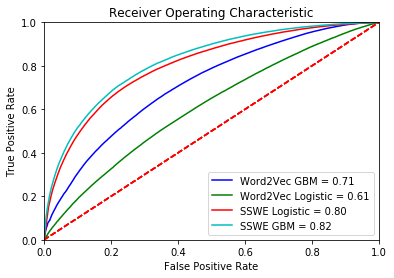

In [7]:
print ('Step1: Loading Testing data')
test_texts = read_data(data_dir+'/testing_text.csv')
test_labels = read_labels(data_dir+'/testing_label.csv')

print ('Step2: Loading word2vec embedding')
vectors_file = r'../02_modeling/vectors/embeddings_Word2Vec_Basic.tsv'
vectors_dc_word2vec = load_word_embedding(vectors_file)

print ('Step2: Loading SSWE embedding')
vectors_file = r'../02_modeling/vectors/embeddings_SSWE_Basic_Keras_w_CNTK.tsv'
vectors_dc_sswe = load_word_embedding(vectors_file)

print ('Step3: Converting word vectors to sentence vectors for w2v')
w2v_sentence_vectors = get_sentence_embedding(test_texts, vectors_dc_word2vec)

print ('Step3: Converting word vectors to sentence vectors for sswe')
sswe_sentence_vectors = get_sentence_embedding(test_texts, vectors_dc_sswe)

w2v_log = r'../02_modeling/model/evaluation_word2vec_logistic'
w2v_gbm = r'../02_modeling/model/evaluation_word2vec_gbm'
sswe_log = r'../02_modeling/model/evaluation_SSWE_logistic'
sswe_gbm = r'../02_modeling/model/evaluation_SSWE_gbm'

model2vectors = {w2v_log:w2v_sentence_vectors,w2v_gbm:w2v_sentence_vectors,
               sswe_log:sswe_sentence_vectors,sswe_gbm:sswe_sentence_vectors}

names = {w2v_log:'Word2Vec Logistic',w2v_gbm:'Word2Vec GBM', sswe_log:'SSWE Logistic',sswe_gbm:'SSWE GBM'}

results={}
for model_file in model2vectors:
    print (model_file)
    try:
        model = load_model(model_file)
        test_sentence_vectors = model2vectors[model_file]
        test_x = np.array(test_sentence_vectors).astype('float32')
        test_y = np.array(test_labels)
        predictions = model.predict(test_x)
        y_pred = np.argmax(predictions, axis=1)
        y_pred_pos = predictions[:,1]
    except:
        model = joblib.load(model_file)
        test_sentence_vectors = model2vectors[model_file]
        test_x = np.array(test_sentence_vectors).astype('float32')
        test_y = np.array(test_labels)
        y_pred = model.predict(test_x)
        
        y_pred_pos = model.predict_proba(test_x)[:, 1]
        pass

    print ('\t Accuracy : %.4f' % metrics.accuracy_score(test_y, y_pred))
    print ('\t Macro-Average Precision : %.4f' % ((metrics.precision_score(test_y, y_pred, pos_label=0) + 
                                                  metrics.precision_score(test_y, y_pred, pos_label=1))/2))
    print ('\t Macro-Average Recall : %.4f' % ((metrics.recall_score(test_y, y_pred, pos_label=0) + 
                                               metrics.recall_score(test_y, y_pred, pos_label=1))/2))
    print ('\t Macro-Average F1 : %.4f' % ((metrics.f1_score(test_y, y_pred, pos_label=0) 
                                           + metrics.f1_score(test_y, y_pred, pos_label=1))/2))
    fpr,tpr,thresh = metrics.roc_curve(test_y, y_pred_pos)
    results[model_file]=(fpr,tpr, thresh)

colors = ['b','g','r','c']
plt.figure(0).clf()
i=0
for each in results:
    fpr,tpr,thresh=results[each]
    roc_auc=metrics.auc(fpr,tpr,'macro')
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, colors[i], label = '%s = %0.2f' % (names[each],roc_auc))
    i+=1
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()